# TODO 

Fix : Parent Dir problem

# Imports

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
dt.datetime.strptime
sns.set_theme(color_codes=True)

In [2]:
import sys
import os


# Get the current directory
current_dir = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current_dir)
parent_p = os.path.dirname(parent)
print(current_dir)
print(parent)
print(parent_p)

# Add the parent directory to sys.path
#parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_p)

/Users/ropereira/Desktop/Projects/stock_forecast/notebooks
/Users/ropereira/Desktop/Projects/stock_forecast
/Users/ropereira/Desktop/Projects


# Data Reading

In [3]:
startdate = dt.datetime(1990,1,1)
enddate = dt.datetime(2023,10,11)
stock = 'MELI'

df = pdr.get_data_yahoo(stock, start=startdate, end=enddate)

df.columns = df.columns.str.lower()
df.head()

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
Date,,,,,,
2007-08-10,22.000000,29.000000,21.000000,28.500000,27.616430,9800300
2007-08-13,31.200001,39.669998,29.000000,31.650000,30.668779,3162100
2007-08-14,32.450001,32.700001,29.980000,30.030001,29.099005,609300
2007-08-15,30.209999,30.209999,28.049999,28.559999,27.674572,991800
2007-08-16,28.250000,30.000000,25.059999,28.100000,27.228842,1107500


In [37]:
name = f'{stock}_{startdate.strftime("%Y:%m:%d")}_{enddate.strftime("%Y:%m:%d")}'
joblib.dump(df, f'../../data/raw/{name}')

['../../data/raw/MELI_1990:01:01_2023:10:11']

In [39]:
ds_data = joblib.load("../../data/raw/MELI_1990:01:01_2023:10:11")

<Axes: xlabel='Date'>

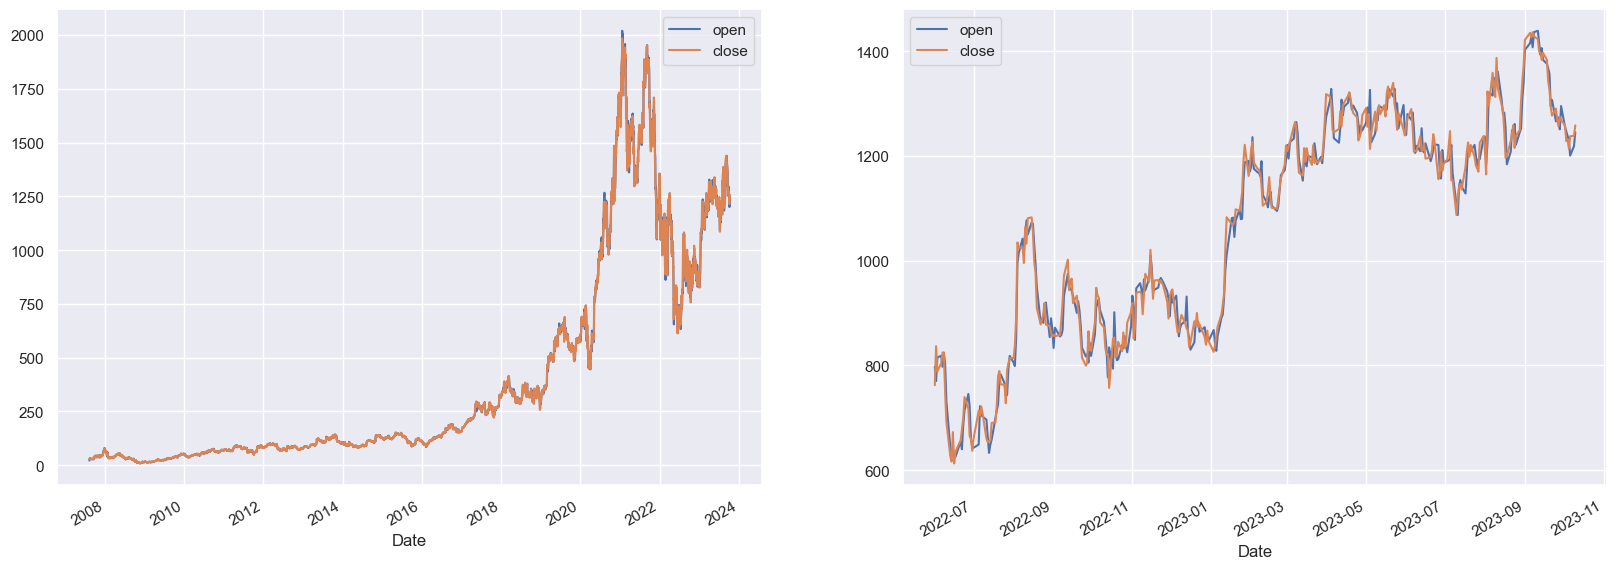

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (20, 7))

ds_data[['open', 'close']].plot( ax = axs[0])
ds_data.loc['2022-06-01':][['open', 'close']].plot( ax = axs[1])

# Define Date Indexs for Train - Test - Eval - Forecast

In [48]:
# 23 days Periods ( Aprox 1 month,  Buisiness Days only)
day_periods = 23

# 1 Month for evaluation
dt_eval_idx = pd.bdate_range(end=ds_data.index[-1], periods=day_periods, freq='B') 

# 3 Month for testing and prediction interval calculation
dt_test_idx = pd.bdate_range(end = dt_eval_idx[0], periods=day_periods * 3, freq='B', inclusive = 'left') 

# Rest for Training , exluding first 23 days for feature computation
dt_start_training_idx = pd.bdate_range(start=ds_data.index[0] , periods=day_periods +2 , freq='B') [-1]
dt_training_idx = pd.bdate_range(start = dt_start_training_idx , end = dt_test_idx[0] , freq='B', inclusive = 'left') 

# 1 Month forecast
dt_forecast_idx = pd.bdate_range(start=dt_eval_idx[-1], periods=day_periods, freq='B') 

print(f' Train start : {dt_training_idx[0]} , end : {dt_training_idx[-1]}')
print(f' Test start : {dt_test_idx[0]} , end : {dt_test_idx[-1]}')
print(f' Eval start : {dt_eval_idx[0]} , end : {dt_eval_idx[-1]}')
print(f' Forecast start : {dt_forecast_idx[0]} , end : {dt_forecast_idx[-1]}')

 Train start : 2007-09-13 00:00:00 , end : 2023-06-05 00:00:00
 Test start : 2023-06-06 00:00:00 , end : 2023-09-07 00:00:00
 Eval start : 2023-09-08 00:00:00 , end : 2023-10-10 00:00:00
 Forecast start : 2023-10-10 00:00:00 , end : 2023-11-09 00:00:00


# Target and feature computation

### Compute Target features

In [49]:
ds_data = fe.compute_target_feature(ds_data)
ds_data

,open,high,low,close,adj close,volume,target_1d,target_5d,target_10d,target_23d
Date,,,,,,,,,,
2007-08-10,22.000000,29.000000,21.000000,28.500000,27.616436,9800300,31.200001,30.320000,29.160000,29.200001
2007-08-13,31.200001,39.669998,29.000000,31.650000,30.668779,3162100,32.450001,32.900002,29.370001,28.610001
2007-08-14,32.450001,32.700001,29.980000,30.030001,29.098999,609300,30.209999,29.709999,29.299999,28.250000
2007-08-15,30.209999,30.209999,28.049999,28.559999,27.674578,991800,28.250000,29.150000,29.520000,27.750000
2007-08-16,28.250000,30.000000,25.059999,28.100000,27.228842,1107500,30.320000,30.889999,29.750000,30.100000
...,...,...,...,...,...,...,...,...,...,...
2023-10-04,1238.229980,1242.000000,1222.319946,1231.560059,1231.560059,218400,1230.000000,NaN,NaN,NaN
2023-10-05,1230.000000,1230.000000,1198.510010,1214.380005,1214.380005,351600,1200.619995,NaN,NaN,NaN
2023-10-06,1200.619995,1243.000000,1190.010010,1237.530029,1237.530029,303300,1218.829956,NaN,NaN,NaN


### Compute Lag features

In [50]:
ds_data = fe.compute_lag_features(ds_data)

# Splitting datasets

In [54]:
target = fe.get_target_columns()
features = fe.get_features_columns()

ds_train =  ds_data.loc[dt_training_idx[0] : dt_training_idx[-1]]
ds_test =  ds_data.loc[dt_test_idx[0] : dt_test_idx[-1]]
ds_eval = ds_data.loc[dt_eval_idx[0] : dt_eval_idx[-2]]
ds_forecast = ds_data.loc[dt_eval_idx[-1]:]

print(f' Train start : {ds_train.index[0]} , end : {ds_train.index[-1]}')
print(f' Test start : {ds_test.index[0]} , end : {ds_test.index[-1]}')
print(f' Eval start : {ds_eval.index[0]} , end : {ds_eval.index[-1]}')
print(f' Forecast day start : {ds_forecast.index[0]} , end : {ds_forecast.index[-1]}')

 Train start : 2007-09-13 00:00:00 , end : 2023-06-05 00:00:00
 Test start : 2023-06-06 00:00:00 , end : 2023-09-07 00:00:00
 Eval start : 2023-09-08 00:00:00 , end : 2023-10-09 00:00:00
 Forecast day start : 2023-10-10 00:00:00 , end : 2023-10-10 00:00:00


In [55]:
# Chequeo de nulls
ds_eval.columns[ds_eval.isna().any()]
ds_eval.columns[ (ds_eval.isna().sum() * 100 / ds_eval.shape[0]) > 0 ]


Index(['target_5d', 'target_10d', 'target_23d'], dtype='object')

In [56]:
# Null Check on forecast row
ds_forecast.columns[ (ds_forecast.isna().sum() * 100 / ds_forecast.shape[0]) > 0 ]

Index(['target_1d', 'target_5d', 'target_10d', 'target_23d'], dtype='object')

In [57]:
# Null Check on Training row
ds_train.columns[ (ds_train.isna().sum() * 100 / ds_train.shape[0]) > 0 ]

Index([], dtype='object')

In [61]:
joblib.dump(ds_forecast, "../../data/processed/ds_train")
joblib.dump(ds_forecast, "../../data/processed/ds_test")
joblib.dump(ds_forecast, "../../data/processed/ds_eval")
joblib.dump(ds_forecast, "../../data/processed/ds_forecast")

['../data/processed/ds_forecast']

In [1]:
list_ = [{"method":"extract"}, {"method":"transform"}, {"method":"load"}]
methods = [i['method'] for i in list_]

[{'method': 'extract'}, {'method': 'transform'}, {'method': 'load'}]